### Step 1: Import Libraries and Set Seed

In [104]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import ParameterGrid, KFold, train_test_split
import matplotlib.pyplot as plt

torch.manual_seed(7)  # Set seed for reproducibility
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
EPOCHS = 50  # Adjust epochs for demonstration
BATCH_SIZE = 64  # Batch size
K_FOLDS = 5

cuda:0


### Step 2: Load and Preprocess the KMNIST Dataset

In [105]:
# Load dataset and compute mean, stddev for normalization
transform = transforms.Compose([transforms.ToTensor()])
dataset = KMNIST(root='./pt_data', train=True, download=True, transform=transform)
trainloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
data = next(iter(trainloader))
mean, stddev = data[0].mean(), data[0].std()

# Transform with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, stddev)])
dataset = KMNIST(root='./pt_data', train=True, download=True, transform=transform)

# Step 1: Split dataset into train and test sets
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

### Step 3: Define the Model

In [106]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.flatten = nn.Flatten()]
        
        # Adjusted hidden layers to 128 and 64 neurons
        self.fc1 = nn.Linear(28 * 28, 128)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(64, 10)  # Output layer

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout1(nn.ReLU()(self.bn1(self.fc1(x))))  # ReLU activation for hidden layer 1
        x = self.dropout2(nn.ReLU()(self.bn2(self.fc2(x))))  # ReLU activation for hidden layer 2
        x = nn.Softmax(dim=1)(self.fc3(x))  # Softmax activation for output layer
        return x

model = NNModel().to(device)

### Step 4: Define Training and Evaluation Functions

In [107]:
def train_model(model, trainloader, optimizer, loss_function, epochs):
    model.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    train_loss = 0.0
    train_correct = 0
    train_batches = 0

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            _, indices = torch.max(outputs.data, 1)
            train_correct += (indices == targets).sum().item()
            train_batches += 1
            train_loss += loss.item()

        train_loss /= train_batches
        train_acc = 100. * train_correct / (train_batches * BATCH_SIZE)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    total_time = time.time() - start_time
    train_loss /= train_batches
    train_acc = 100. * train_correct / (train_batches * BATCH_SIZE)

    return train_loss, train_acc, total_time

def evaluate_model(model, testloader, loss_function):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_batches = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            _, indices = torch.max(outputs, 1)
            test_correct += (indices == targets).sum().item()
            test_batches += 1
            test_loss += loss.item()

    test_loss /= test_batches
    test_acc = 100. * test_correct / (test_batches * BATCH_SIZE)
    return test_loss, test_acc

### Step 5: Perform Hyperparameter Tuning and Evaluation

In [108]:
kf = KFold(n_splits=K_FOLDS, shuffle=True)

param_grid = {
    'optimizer': ['adam', 'rmsprop', 'adamw'],
    'learning_rate': [0.001, 0.0005, 0.0001]
}

param_combinations = list(ParameterGrid(param_grid))

results = []
for params in param_combinations:
    print(f"Testing combination: {params}")
    fold_results = []

    for fold, (train_ids, val_ids) in enumerate(kf.split(train_subset)):
        print(f"Fold {fold + 1}/5")

        # Create training and validation subsets
        train_data = Subset(train_subset, train_ids)
        val_data = Subset(train_subset, val_ids)

        # Loaders
        trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

        # Initialize model
        model = NNModel().to(device)

        # Optimizer setup
        if params['optimizer'] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        elif params['optimizer'] == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=params['learning_rate'])
        elif params['optimizer'] == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])

        # Train model
        train_loss, train_acc, train_time = train_model(model, trainloader, optimizer, nn.CrossEntropyLoss(), EPOCHS)

        # Validate model
        val_loss, val_acc = evaluate_model(model, valloader, nn.CrossEntropyLoss())
        print(f"Fold {fold+1} Val Accuracy: {val_acc:.2f}%")

        fold_results.append({
            'fold': fold + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'train_time': train_time
        })

    # Averaging fold results
    avg_result = pd.DataFrame(fold_results).mean()
    avg_result['optimizer'] = params['optimizer']
    avg_result['learning_rate'] = params['learning_rate']
    results.append(avg_result)



Testing combination: {'learning_rate': 0.001, 'optimizer': 'adam'}
Fold 1/5
Epoch 1/50, Train Loss: 1.6972, Train Accuracy: 81.80%
Epoch 2/50, Train Loss: 0.7880, Train Accuracy: 85.95%
Epoch 3/50, Train Loss: 0.5169, Train Accuracy: 87.96%
Epoch 4/50, Train Loss: 0.3849, Train Accuracy: 89.19%
Epoch 5/50, Train Loss: 0.3062, Train Accuracy: 90.07%
Epoch 6/50, Train Loss: 0.2539, Train Accuracy: 90.77%
Epoch 7/50, Train Loss: 0.2171, Train Accuracy: 91.32%
Epoch 8/50, Train Loss: 0.1897, Train Accuracy: 91.74%
Epoch 9/50, Train Loss: 0.1683, Train Accuracy: 92.10%
Epoch 10/50, Train Loss: 0.1511, Train Accuracy: 92.43%
Epoch 11/50, Train Loss: 0.1371, Train Accuracy: 92.72%
Epoch 12/50, Train Loss: 0.1256, Train Accuracy: 92.97%
Epoch 13/50, Train Loss: 0.1157, Train Accuracy: 93.20%
Epoch 14/50, Train Loss: 0.1074, Train Accuracy: 93.40%
Epoch 15/50, Train Loss: 0.1002, Train Accuracy: 93.57%
Epoch 16/50, Train Loss: 0.0935, Train Accuracy: 93.77%
Epoch 17/50, Train Loss: 0.0879, Trai

In [109]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.head()

,fold,train_loss,train_acc,val_loss,val_acc,train_time,optimizer,learning_rate
0,3.0,9.904935e-07,96.306448,1.504776,95.743750,253.853612,adam,0.0010
1,3.0,9.907931e-07,96.276406,1.505536,95.641667,247.171201,rmsprop,0.0010
2,3.0,9.898841e-07,96.353281,1.505270,95.675000,247.621127,adamw,0.0010
3,3.0,9.917284e-07,96.171635,1.507463,95.495833,248.422042,adam,0.0005
4,3.0,9.918761e-07,96.187656,1.509021,95.368750,246.478007,rmsprop,0.0005


### Step 6: Display Results

In [110]:
testloader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

best_params = results_df.loc[results_df['val_acc'].idxmax()]
print(f"Best hyperparameters: {best_params}")

# Re-train with best hyperparameters and test
model = NNModel().to(device)
if best_params['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['learning_rate'])

# Final training on entire training set (no validation now)
trainloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
train_model(model, trainloader, optimizer, nn.CrossEntropyLoss(), EPOCHS)

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, testloader, nn.CrossEntropyLoss())
print(f"Test Accuracy: {test_acc:.2f}%")
results_df['test_acc'] = test_acc
results_df['test_loss'] = test_loss

# Generate tables
results_df[['optimizer', 'learning_rate', 'train_acc', 'val_acc', 'test_acc', 'train_loss', 'val_loss', 'test_loss', 'train_time']].head()

Best hyperparameters: fold                    3.0
train_loss         0.000001
train_acc         96.306448
val_loss           1.504776
val_acc            95.74375
train_time       253.853612
optimizer              adam
learning_rate         0.001
Name: 0, dtype: object
Epoch 1/50, Train Loss: 1.6946, Train Accuracy: 80.55%
Epoch 2/50, Train Loss: 0.7859, Train Accuracy: 85.38%
Epoch 3/50, Train Loss: 0.5160, Train Accuracy: 87.65%
Epoch 4/50, Train Loss: 0.3842, Train Accuracy: 89.01%
Epoch 5/50, Train Loss: 0.3058, Train Accuracy: 89.94%
Epoch 6/50, Train Loss: 0.2538, Train Accuracy: 90.67%
Epoch 7/50, Train Loss: 0.2170, Train Accuracy: 91.22%
Epoch 8/50, Train Loss: 0.1896, Train Accuracy: 91.67%
Epoch 9/50, Train Loss: 0.1680, Train Accuracy: 92.06%
Epoch 10/50, Train Loss: 0.1511, Train Accuracy: 92.39%
Epoch 11/50, Train Loss: 0.1371, Train Accuracy: 92.67%
Epoch 12/50, Train Loss: 0.1256, Train Accuracy: 92.91%
Epoch 13/50, Train Loss: 0.1158, Train Accuracy: 93.14%
Epoch 14/50,

,optimizer,learning_rate,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss,train_time
0,adam,0.0010,96.306448,95.743750,95.827793,9.904935e-07,1.504776,1.500707,253.853612
1,rmsprop,0.0010,96.276406,95.641667,95.827793,9.907931e-07,1.505536,1.500707,247.171201
2,adamw,0.0010,96.353281,95.675000,95.827793,9.898841e-07,1.505270,1.500707,247.621127
3,adam,0.0005,96.171635,95.495833,95.827793,9.917284e-07,1.507463,1.500707,248.422042
4,rmsprop,0.0005,96.187656,95.368750,95.827793,9.918761e-07,1.509021,1.500707,246.478007


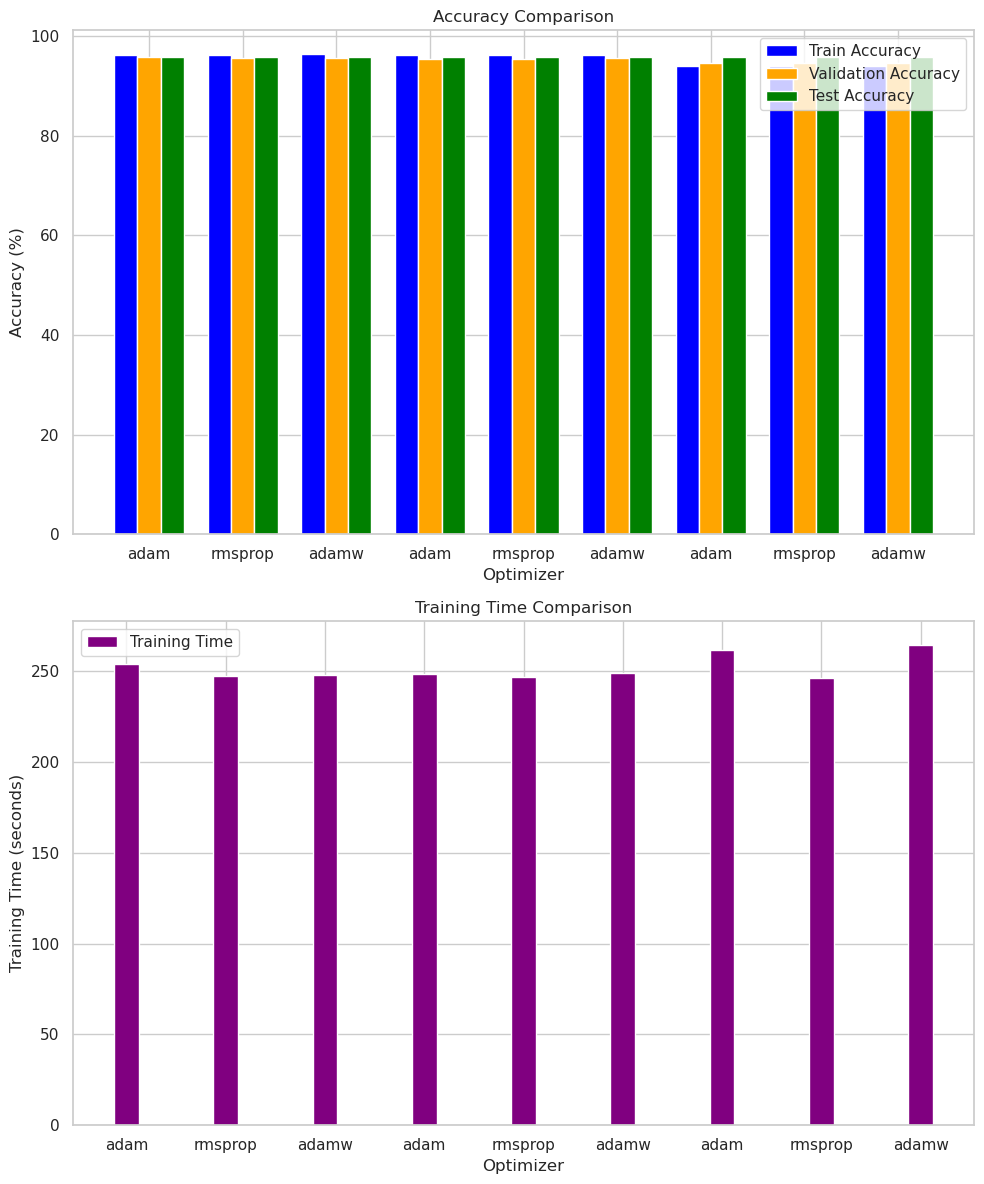

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two vertical subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

### Subplot 1: Accuracy Comparison (Vertical Bar Plot) ###
bar_width = 0.25
optimizers = np.arange(len(results_df['optimizer']))

# Plot bars for train, validation, and test accuracy
ax1.bar(optimizers, results_df['train_acc'], bar_width, label='Train Accuracy', color='blue')
ax1.bar(optimizers + bar_width, results_df['val_acc'], bar_width, label='Validation Accuracy', color='orange')
ax1.bar(optimizers + 2 * bar_width, results_df['test_acc'], bar_width, label='Test Accuracy', color='green')

# Labels and title for accuracy plot
ax1.set_title('Accuracy Comparison')
ax1.set_xlabel('Optimizer')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks(optimizers + bar_width)
ax1.set_xticklabels(results_df['optimizer'])
ax1.legend(loc='best')

### Subplot 2: Training Time Comparison (Vertical Bar Plot) ###
ax2.bar(optimizers, results_df['train_time'], bar_width, color='purple', label='Training Time')

# Labels and title for training time plot
ax2.set_title('Training Time Comparison')
ax2.set_xlabel('Optimizer')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_xticks(optimizers)
ax2.set_xticklabels(results_df['optimizer'])
ax2.legend(loc='best')

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show combined plot
plt.show()
